In [1]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import csv
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [3]:
import datasets
import torchvision.transforms as transforms

tensor_transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.C100Dataset('dataset/data/cifar100_nl.csv', 'dataset/data/cifar100_nl_test.csv')
[trainData, trainLabels, valData, valLabels] = dataset.getDataset()




49999
49999
9999
9999


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming trainData, trainLabels, valData, and valLabels are numpy arrays

# Convert numpy arrays to torch tensors
trainData = torch.from_numpy(trainData)
trainLabels = torch.from_numpy(trainLabels)
valData = torch.from_numpy(valData)
valLabels = torch.from_numpy(valLabels)

# Create TensorDatasets
trainDataset = TensorDataset(trainData, trainLabels)
valDataset = TensorDataset(valData, valLabels)

# Create DataLoaders
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False)

In [16]:
train_iter = iter(trainLoader)
images, labels = next(train_iter)

print(images.shape)
labels.shape

torch.Size([64, 32, 32, 3])


torch.Size([64])

Pictures for fun

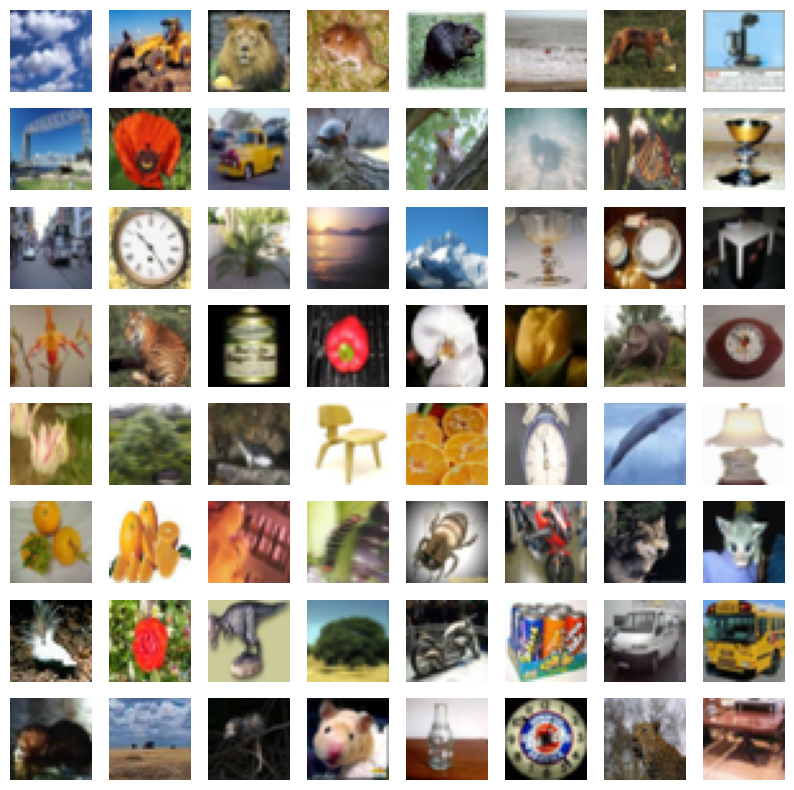

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the images tensor to a numpy array
image_array = images.numpy()

# Rescale the pixel values between 0 and 1 (if necessary)
image_array = image_array / 255.0

# Create a grid of images
grid = np.transpose(image_array, (0, 1, 2, 3))  # Reshape from (batch_size, height, width, channels) to (batch_size, width, height, channels)
grid = np.squeeze(grid)  # Remove any single-dimensional entries from the shape

# Create a figure and axes
fig, axes = plt.subplots(8, 8, figsize=(10, 10))

# Display each image in the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(grid[i])
    ax.axis('off')

# Show the plot
plt.show()


Model Architecture

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageClassifier(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super(ImageClassifier, self).__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, self.num_classes)
    
    def forward(self, x, labels):
        x = x.float().to(self.conv1.weight.device)
        x = self.bn1(F.relu(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.bn2(F.relu(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.reshape(x.size(0), -1)
        x = self.bn3(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        smoothed_labels = torch.full_like(x, self.smoothing / (self.num_classes - 1))
        smoothed_labels.scatter_(1, labels.unsqueeze(1), 1 - self.smoothing)
        
        return F.log_softmax(x, dim=1)


Model training

In [47]:
import torch.optim as optim

classifier_model = ImageClassifier(100)
loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(classifier_model.parameters(), lr=0.001, momentum = 0.9)

In [49]:
for epoch in range(0,10):
    running_loss = 0.0
    for i, batch in enumerate(trainLoader, 0):
        images, labels = batch
        images = images.permute(0,3,1,2)
        optimiser.zero_grad()
        
        logits = classifier_model(images, labels)
        loss = loss_function(logits, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item() 
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch +1, i+1, running_loss/2000))
            running_loss = 0.0
        
print('Finished Training')

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

Evaluation

In [41]:
correct = 0
total = 0

with torch.no_grad():
    for data in valLoader:
        images, labels = data
        images = images.permute(0,3,1,2)
        outputs = classifier_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy on the 10000 test images: 32 %
